In [ ]:
# Execute this cell to install dependencies
%pip install sf-hamilton[visualization] polars

# Polars materialization [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dagworks-inc/hamilton/blob/main/examples/polars/notebook.ipynb) [![GitHub badge](https://img.shields.io/badge/github-view_source-2b3137?logo=github)](https://github.com/dagworks-inc/hamilton/blob/main/examples/polars/notebook.ipynb)


In [1]:
%load_ext hamilton.plugins.jupyter_magic

/Users/jernejfrank/miniconda3/envs/hamilton/lib/python3.10/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
/Users/jernejfrank/miniconda3/envs/hamilton/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


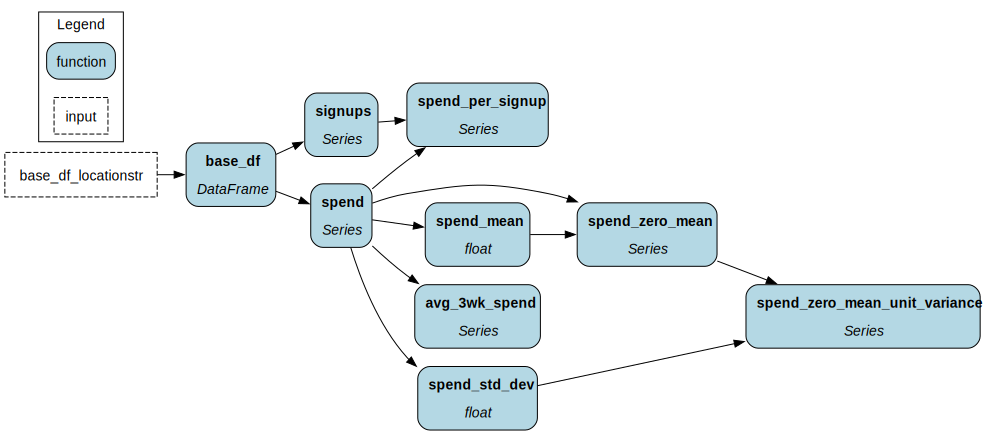

In [2]:
%%cell_to_module spend_calculations --display

import polars as pl
from hamilton.function_modifiers import extract_columns

@extract_columns("signups", "spend")
def base_df(base_df_location: str) -> pl.DataFrame:
    """Loads base dataframe of data.

    :param base_df_location: just showing that we could load this from a file...
    :return:
    """
    return pl.DataFrame(
        {
            "signups": pl.Series([1, 10, 50, 100, 200, 400]),
            "spend": pl.Series([10, 10, 20, 40, 40, 50]),
        }
    )

def avg_3wk_spend(spend: pl.Series) -> pl.Series:
    """Rolling 3 week average spend."""
    return spend.rolling_mean(3)

def spend_per_signup(spend: pl.Series, signups: pl.Series) -> pl.Series:
    """The cost per signup in relation to spend."""
    return spend / signups

def spend_mean(spend: pl.Series) -> float:
    """Shows function creating a scalar. In this case it computes the mean of the entire column."""
    return spend.mean()

def spend_zero_mean(spend: pl.Series, spend_mean: float) -> pl.Series:
    """Shows function that takes a scalar. In this case to zero mean spend."""
    return spend - spend_mean

def spend_std_dev(spend: pl.Series) -> float:
    """Function that computes the standard deviation of the spend column."""
    return spend.std()

def spend_zero_mean_unit_variance(spend_zero_mean: pl.Series, spend_std_dev: float) -> pl.Series:
    """Function showing one way to make spend have zero mean and unit variance."""
    return spend_zero_mean / spend_std_dev

In [3]:
from hamilton import driver, base
from hamilton.plugins import h_polars

inputs = {
    "base_df_location": "dummy_value",
}
adapter = base.SimplePythonGraphAdapter(result_builder=h_polars.PolarsDataFrameResult())
dr = (driver
      .Builder()
      .with_modules(spend_calculations)
      .with_adapters(adapter)
      .build()
)

output_columns = [
    "spend",
    "signups",
    "avg_3wk_spend",
    "spend_per_signup",
    "spend_zero_mean_unit_variance",
]

shape: (6, 5)
┌───────┬─────────┬───────────────┬──────────────────┬───────────────────────────────┐
│ spend ┆ signups ┆ avg_3wk_spend ┆ spend_per_signup ┆ spend_zero_mean_unit_variance │
│ ---   ┆ ---     ┆ ---           ┆ ---              ┆ ---                           │
│ i64   ┆ i64     ┆ f64           ┆ f64              ┆ f64                           │
╞═══════╪═════════╪═══════════════╪══════════════════╪═══════════════════════════════╡
│ 10    ┆ 1       ┆ null          ┆ 10.0             ┆ -1.064405                     │
│ 10    ┆ 10      ┆ null          ┆ 1.0              ┆ -1.064405                     │
│ 20    ┆ 50      ┆ 13.333333     ┆ 0.4              ┆ -0.483821                     │
│ 40    ┆ 100     ┆ 23.333333     ┆ 0.4              ┆ 0.677349                      │
│ 40    ┆ 200     ┆ 33.333333     ┆ 0.2              ┆ 0.677349                      │
│ 50    ┆ 400     ┆ 43.333333     ┆ 0.125            ┆ 1.257934                      │
└───────┴─────────┴──────────

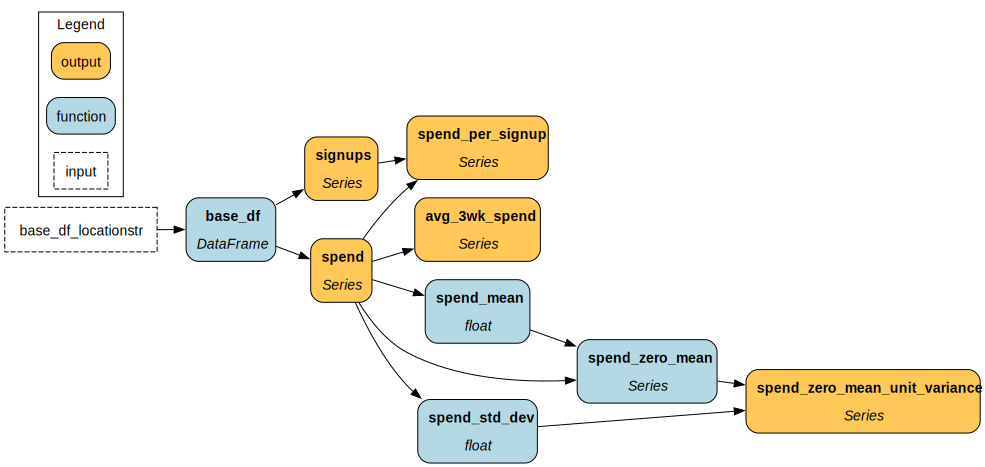

In [4]:
# Execute the driver.

df = dr.execute(output_columns, inputs=inputs)
print(df)

# To visualize do `pip install "sf-hamilton[visualization]"` if you want these to work
dr.visualize_execution(output_columns, inputs=inputs)

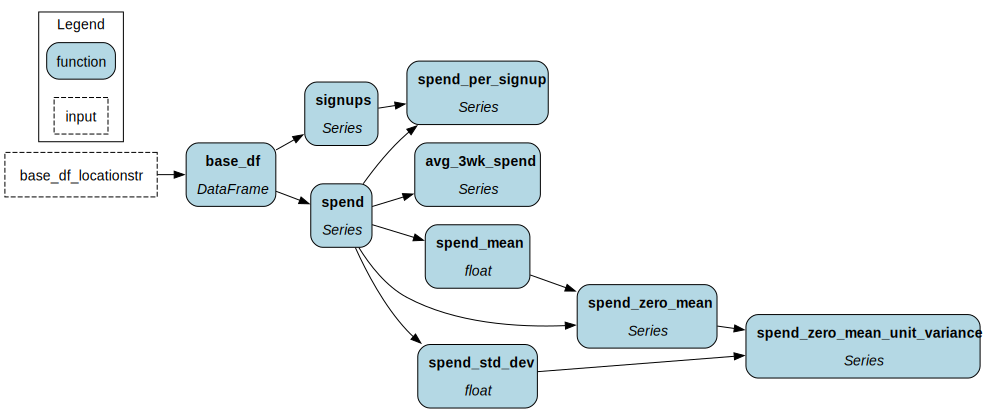

In [5]:
dr.display_all_functions()